# Design Space Exploration with Kriging

This notebook is an exploration of using kriging models to approximate complex response surfaces. The kriging model is a flexible metamodel that can reproduce complex response surfaces given a limited number of observations. The kriging model is a statistics-based model that can include both a traditional response surface and a kernel-based, spatial correlation model.

The desire is to use the prediction capability of the model to drive the exploration of the design space. The methodology controls an adapative design of experiments and also an assessment of the quality of the model based upon the observations used to create the model.

For this example, the Mystery function is used as defined below. This is a two-dimensional function defined over $[0,5]^2$ but is scaled to function over the unit square $[0,1]^2$. This function is highly nonlinear in both dimensions and has multiple waves that are a function of both input dimensions.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def Mystery(x0, x1):
    x0=5*x0
    x1=5*x1
    y = 2+0.01*pow((x1-x0*x0),2)+pow((1-x0),2)+2*pow((2-x1),2)+7*np.sin(0.5*x0)*np.sin(0.7*x0*x1)
    return y

The function can be evaluated as shown next.

In [3]:
Mystery(2.5044/5, 2.5778/5)

-1.4565257761813282

The first step in this process is to provide a visualization of the original response surface. This is completed by evaluating the model over a grid of $100x100$ observations. It is then plotted below. 

In [4]:
dx = np.linspace(0, 1, 100)
dy = np.linspace(0, 1, 100)
X, Y = np.meshgrid(dx, dy)
Z = Mystery(X, Y)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


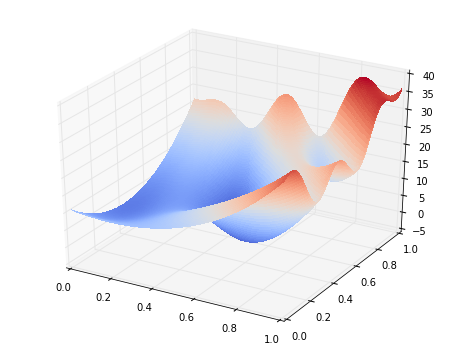

In [5]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Fixed Design of Experiments

Here are 21 locations within the model's domain selected using a Latin Hypercube Sampling (LHS) Design of Experiments (DoE)

(0, 1)

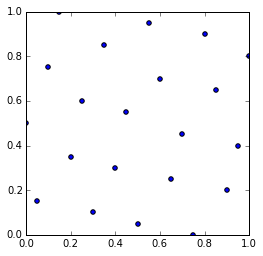

In [6]:
data=np.array([[0.0, 0.5],
      [0.05, 0.15],
      [0.1, 0.75],
      [0.15, 1.0],
      [0.2, 0.35],
      [0.25, 0.6],
      [0.3, 0.1],
      [0.35, 0.85],
      [0.4, 0.3],
      [0.45, 0.55],
      [0.5, 0.05],
      [0.55, 0.95],
      [0.6, 0.7],
      [0.65, 0.25],
      [0.7, 0.45],
      [0.75, 0.0],
      [0.8, 0.9],
      [0.85, 0.65],
      [0.9, 0.2],
      [0.95, 0.4],
      [1.0, 0.8]])

X0=data[:,0]
X1=data[:,1] 

fig, ax = subplots(1,1,figsize=(4,4))
ax.scatter(X0,X1)
ax.set_ylim([0,1])
ax.set_xlim([0,1])

The original model is evaluated at the 21 locations and the two X vectors are assembled into a single matrix. This matrix and the vector of observations, Y, are passed to the Kriging Model creation code.

In [7]:
Y = Mystery(X0,X1)
X=np.array([X0, X1]).T

In [8]:
from kriging.kriging import KrigingModel

In [9]:
k=KrigingModel(X,Y)

The following information is generated as a result of creating the kriging model. They include a representation of what terms are used in the trend model (selected automatically), and trend model coefficients, correlation model range parameters, the corrected AIC, and the overall process variance.

In [10]:
print k.trendModel
print 'beta:',k.beta
print 'corr range:', k.d
print 'corrrected AIC:', k.getAICc()
print 'process variance:', k.processVariance

[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
beta: [ 10.39433029 -43.22045672  20.04947094  52.21602216]
corr range: [ 10.     0.01]
corrrected AIC: 133.015621875
process variance: 11.2377324952


The model can then be evaluated at a location within its domain ($[0,1]^2$).

In [11]:
k.estimate([0.1,0.1])

7.5678815631718619

This can be compared to the original model.

In [12]:
Mystery(0.1, 0.1)

7.0521502980536077

The standard deviation of the model's estimate can be quantified. This metric does not include the uncertainty that exists in predicting the model parameters.

In [13]:
k.stdev([0.1,0.1])

0.0947976311969453

Since the uncertainty that exists in estimating the model parameters is nto included, it is expected that the standard deviation estimate may be an underestimate of the actual standard deviation in the estimates. This can be analyzed by evaluating the kriging model and the actual model at a number of random locations within its domain. The difference between the estimate and the actual value can be normalized by the expected standard deviation at the location and then plotted as a histogram. Additionally, the mean, variance, skewness, and kurtosis can be calculated from the observed normalized errors. The expected mean should be zero, variance should be one, skewness zero, and kurtosis should be three, ie. it should result in a standard normal distribution.

<Container object of 20 artists>

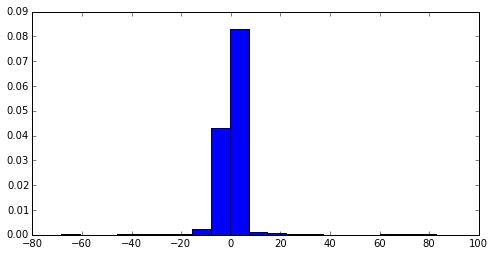

In [14]:
from random import random
num_points = 1000
obs = np.zeros((num_points))
for i in range(num_points):
    x0=random()
    x1=random()
    delta = Mystery(x0,x1)-k.estimate([x0,x1])
    obs[i] = delta/k.stdev([x0,x1])
hist, bins = np.histogram(obs, bins=20, density=True) 
widths = np.diff(bins)

fig, ax = subplots(1,1,figsize=(8,4))
ax.bar(bins[:-1], hist, widths)

In [15]:
from scipy import stats
n, min_max, mean, var, skew, kurt = stats.describe(obs)
print 'mean:',mean
print 'var :', var
print 'skew:', skew
print 'kurt:', kurt

mean: -0.0016776769422
var : 37.8789280426
skew: 3.13695396029
kurt: 86.7799513792


As the reader can see from both the visual inspection of the resulting histogram of the standardized errors of the observation predictions and the description statistics, the standardized errors are not well described with a normal distribution. The mean is good, but the variance is large and is driven by the outliers. These outliers also drive the kurtosis (a measurement of the thickness of the tails) to be much more than the expected value of 3.

Previous research by the author has shown that, by including all of the uncertainty in the model parameters, the resulting distribution is well approximated by the student-t distribution (has thicker tails) and can have a significantly higher variance than that given only by the model variance. In the study of this specific model, it was found that the model parameters only tended to increase the uncertainty by about 20%, which is less than that being observed here.

The following two plots provide a comparison of the response surfaces from the original function and the surrogate model created from 21 observations of the original model.

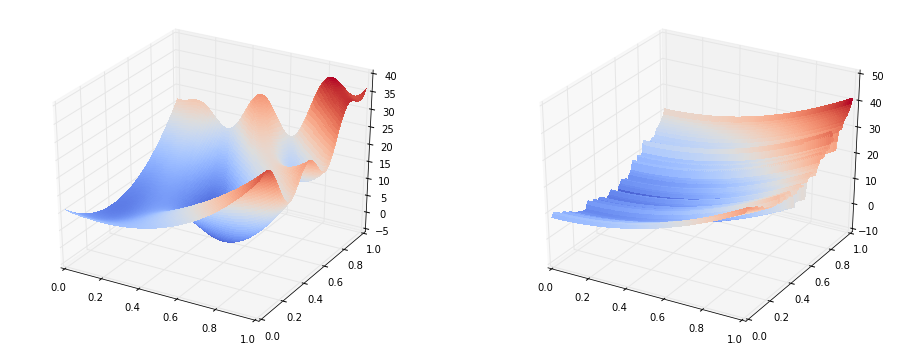

In [16]:
dx = linspace(0, 1, 100)
dy = linspace(0, 1, 100)
X, Y = meshgrid(dx, dy)
Z_est = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z_est[i,j]=k.estimate([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride = 1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 2, projection='3d')
p = ax.plot_surface(X, Y, Z_est, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)


It is difficult to see much of a difference in these plots. It is easier to see the differences in the following plot. The points included in the plot are the observations points. It is expected that the model would interpolate these points. The surface shown does not appear to do so. This is a result of the plotting software 'rounding' of some of the extremely sharp features. The plot below provides the reader with a more qualitative perspective of the error. A more quantative measurement is the root mean square error. The amount of variability in the actual model that is captured by the kriging model can also be quantified.

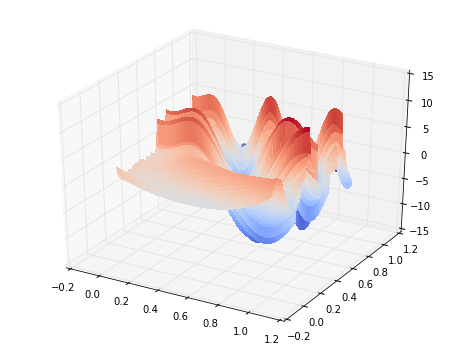

In [17]:
Z_err = np.array(Z-Z_est)
Z_zero = np.zeros((21))-0.0
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X, Y, Z_err, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X0, X1, Z_zero)

In [18]:
print 'RMSE: ', sqrt(np.sum(np.multiply(Z_err, Z_err))/(100*100))
print 'R^2 : ', 1.0-((np.sum(np.multiply(Z_err, Z_err))/(100*100))/np.var(Z))


RMSE:  4.25569531409
R^2 :  0.741310629635


The kriging model is capable of reproducing very complex response surfaces, much more so than polynomial regression models, as can be seen in the example above. The basis of the kriging model is that it is a Gaussian spatial process model, i.e. it assumes that the observations come from a Gaussian spatial process. The form of the kriging model allows one to estimate not only the expected value of the response process represented by the observations of it, but also the standard deviation of those estimates. The following figure plots plus and minus one standard deviation as a wireframe with the actual errors. It can be seen that there is only one region where the model does not appear to do a very good job of predicting the actual surface.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


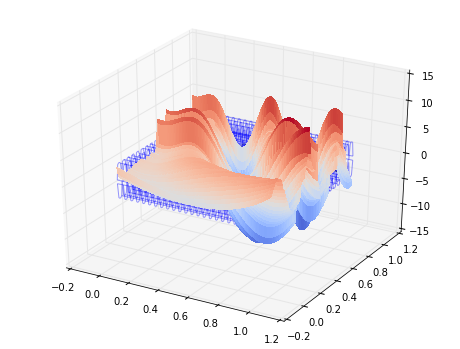

In [19]:
Z_std = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        Z_std[i,j]=k.stdev([X[i,j],Y[i,j]])

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_wireframe(X, Y, Z_std, rstride=4, cstride=4, alpha=0.4)
ax.plot_wireframe(X, Y, -1*Z_std, rstride=4, cstride=4, alpha=0.4)
ax.plot_surface(X,Y,Z_err, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.scatter(X0, X1, Z_zero)


## Adaptive Design of Experiments

It is remarkable the amount of detail that can be reproduced given only 21 observations selected before anything is known about response surface to be reproduced. The use of kriging models was initially considered for use a metamodel not so much for its powerful ability to reproduce response surfaces, but rather for its ability to be an adaptive design of experiment tool - after an initial screening, the locations of maximum standard deviation (or variance or mean square error) is selected to update the kriging model and thus optimally reduce the uncertainty in the response surface.

The 'seed' design in this case will be observations that still come from an LHS type of design. For a two-dimensional function like this, a minimum of 6 observations is needed (1 for trend function, 2 for correlation parameters, 1 for the process variance, and 2 additional degrees of freedom)

In [20]:
x_in=np.array([[0.0, 1.0],
    [0.2, 0.2],
    [0.4, 0.6],
    [0.6, 0.0],
    [0.8, 0.8],
    [1.0, 0.4]])
X_0=x_in[:,0]
X_1=x_in[:,1] 
y_out = Mystery(X_0,X_1)
krig=[]
Z_est = [np.zeros((100,100))]
Z_std = [np.zeros((100,100))]
Z_zero = np.zeros((6))
iea = []
iee = []
ecv = []
stdZ = sqrt(np.var(Z))

l=0

In [21]:
while l<16:
    krig=np.append(krig, [KrigingModel(x_in,y_out)])
    iea = np.append(iea,[0.0])
    iee = np.append(iee,[0.0])
    ecv = np.append(ecv,[0.0])
    for i in range(100):
        for j in range(100):
            Z_est[l][i,j]=krig[l].estimate([X[i,j],Y[i,j]])
            Z_std[l][i,j]=krig[l].stdev([X[i,j],Y[i,j]])
            iee[l]+=Z_std[l][i,j]*Z_std[0][i,j]
            iea[l]+=(Z[i,j]-Z_est[l][i,j])*(Z[i,j]-Z_est[l][i,j])
    iee[l]=sqrt(iee[l]/(100*100))
    iea[l]=sqrt(iea[l]/(100*100))
    ecv[l]=sqrt(krig[l].cvMSE)
    print "added point   : ", l
    print "error estimate: ", 1-pow((iee[l]/stdZ),2)
    print "error actual  : ", 1-pow((iea[l]/stdZ),2)
    print "cv error      : ", 1-pow((ecv[l]/stdZ),2)
    print "variance      : ", stdZ
    best_x0 = 0
    best_x1 = 0
    best_val = Z_std[l][best_x0,best_x1]
    for i in range(100):
        for j in range(100):
            if Z_std[l][i,j]>best_val:
                best_x0 = i
                best_x1 = j
                best_val = Z_std[l][i,j]
    new_point = [X[best_x0,best_x1], Y[best_x0, best_x1]]
    print "added obs     :", best_val, new_point
    y = Mystery(new_point[0],new_point[1])
    y_out = np.append(y_out, y)
    x_in = np.append(x_in,[new_point], axis=0)
    Z_est = np.append(Z_est, [np.zeros((100,100))], axis=0)
    Z_std = np.append(Z_std, [np.zeros((100,100))], axis=0)
    Z_zero = np.append(Z_zero,[0.0])
    l=l+1


added point   :  0
error estimate:  0.797031154812
error actual  :  0.268160068377
cv error      :  0.276634961998
variance      :  8.36722090907
added obs     : 6.63905533423 [1.0, 1.0]
added point   :  1
error estimate:  0.684073904392
error actual  :  0.263937718066
cv error      :  -0.0418817870734
variance      :  8.36722090907
added obs     : 9.880618832 [0.0, 0.0]
added point   :  2
error estimate:  0.459358586386
error actual  :  -0.159283541372
cv error      :  -0.626769225793
variance      :  8.36722090907
added obs     : 10.6719605045 [0.050505050505050511, 0.0]
added point   :  3
error estimate:  0.482611177144
error actual  :  -0.20418194181
cv error      :  -0.336167552475
variance      :  8.36722090907
added obs     : 10.6218775161 [0.0, 0.050505050505050511]
added point   :  4
error estimate:  0.889180730971
error actual  :  0.523555790805
cv error      :  0.589917093686
variance      :  8.36722090907
added obs     : 5.14116763995 [0.0, 0.71717171717171724]
added point 

(-0.1, 1.1)

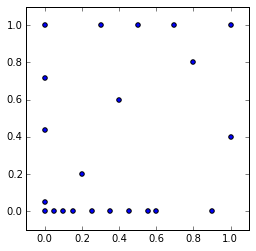

In [22]:
X_0=x_in[:,0]
X_1=x_in[:,1] 
fig, ax = subplots(1,1,figsize=(4,4))
ax.scatter(X_0,X_1)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.1,1.1])

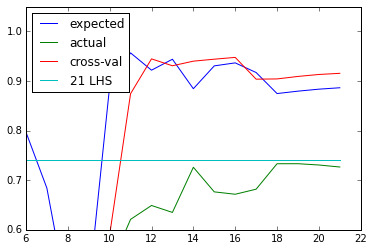

In [23]:
r2_iea=1-pow((iea/stdZ),2)
r2_iee=1-pow((iee/stdZ),2)
r2_ecv=1-pow((ecv/stdZ),2)
e21 = (np.sum(np.multiply(Z_err, Z_err))/(100*100))*np.ones((16))
r2_21 = 1-e21/(stdZ*stdZ)
obs = range(6,22)
fig, ax = subplots(1,1,figsize=(6,4))
ax.plot(obs,r2_iee, label="expected")
ax.plot(obs,r2_iea, label="actual")
ax.plot(obs,r2_ecv, label="cross-val")
ax.plot(obs,r2_21, label="21 LHS")
ax.set_ylim([0.6,1.05])
ax.legend(loc=2)

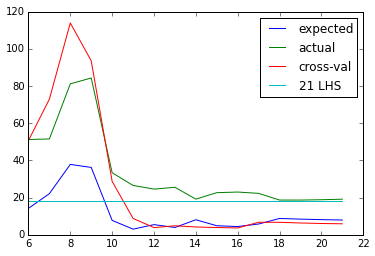

In [24]:
iea2=np.multiply(iea,iea)
iee2=np.multiply(iee,iee)
ecv2=np.multiply(ecv,ecv)
e21_2 = (np.sum(np.multiply(Z_err, Z_err))/(100*100))*np.ones((16))
obs = range(6,22)
fig, ax = subplots(1,1,figsize=(6,4))
ax.plot(obs,iee2, label="expected")
ax.plot(obs,iea2, label="actual")
ax.plot(obs,ecv2, label="cross-val")
ax.plot(obs,e21_2, label="21 LHS")
#ax.set_ylim([0.0,0.02])
ax.legend(loc=1)